# 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from tensorflow.keras import datasets, utils

In [2]:
train = pd.read_csv('./data/train_occpy_pred_final.csv')
test = pd.read_csv('./data/test_occpy_pred_final.csv')

# 데이터 전처리

In [3]:
train.gender = train.gender.replace({'F' : 0, 'M' : 1})
train.car = train.car.replace({'N' : 0, 'Y' : 1})
train.reality = train.reality.replace({'N' : 0, 'Y' : 1})
train['age'] = train.DAYS_BIRTH.apply(lambda x : -x // 365)
train.DAYS_EMPLOYED = (-1) * train.DAYS_EMPLOYED 
train.loc[(train.DAYS_EMPLOYED < 0), 'DAYS_EMPLOYED'] = 0
train.begin_month = (-1) * train.begin_month

train = train.drop(['Unnamed: 0','DAYS_BIRTH'], axis = 1)
train.head(3)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age
0,0,0,0,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,4709,0,0,0,Accountants,2.0,6.0,1.0,38
1,0,0,1,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,1540,0,0,1,Laborers,3.0,5.0,1.0,31
2,1,1,1,0,450000.0,Working,Higher education,Married,House / apartment,4434,0,1,0,Managers,2.0,22.0,2.0,52


In [4]:
test.gender = test.gender.replace({'F' : 0, 'M' : 1})
test.car = test.car.replace({'N' : 0, 'Y' : 1})
test.reality = test.reality.replace({'N' : 0, 'Y' : 1})
test['age'] = test.DAYS_BIRTH.apply(lambda x : -x // 365)
test.DAYS_EMPLOYED = (-1) * test.DAYS_EMPLOYED 
test.loc[(test.DAYS_EMPLOYED < 0), 'DAYS_EMPLOYED'] = 0
test.begin_month = (-1) * test.begin_month

test = test.drop(['Unnamed: 0','DAYS_BIRTH'], axis = 1)
test.head(3)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,age
0,1,1,0,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,0,0,1,0,Security staff,2.0,60.0,60
1,0,0,1,0,135000.0,State servant,Higher education,Married,House / apartment,8671,0,1,0,Core staff,2.0,36.0,51
2,0,0,1,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,217,1,1,0,Laborers,2.0,40.0,43


In [5]:
print(train.shape, test.shape)

(26457, 18) (10000, 17)


In [6]:
y = train.credit
X = train.drop(['credit'], axis = 1)

# 데이터 분할

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)

# 데이터 인코딩

In [8]:
numeric_features = ['child_num', 'income_total', 'DAYS_EMPLOYED', 'family_size', 'begin_month', 'age']
numeric_transformer = StandardScaler()

categorical_features = ['income_type', 'edu_type', 'family_type', 'house_type','occyp_type']
categorical_transformer = OneHotEncoder(categories='auto', handle_unknown = 'ignore')


preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)
                ], remainder='passthrough'
                )

In [9]:
preprocessor.fit(X_train)
scaled_X_train = preprocessor.transform(X_train)
scaled_X_val = preprocessor.transform(X_val)

# DNN

In [10]:
import tensorflow as tf
from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing

In [11]:
train_label = utils.to_categorical(y_train) # 0~9 -> one-hot vector
val_label = utils.to_categorical(y_val) # 0~9 -> one-hot vector

In [13]:
scaled_X_train.shape[1]

51

## layer2

### (256,256)

In [14]:
model = models.Sequential()

# 1-hidden layer
model.add(layers.Dense(input_dim=scaled_X_train.shape[1], units=256, activation=None, kernel_initializer='he_uniform'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(rate=0.3))

# 2-hidden layer
model.add(layers.Dense(units=256, activation=None, kernel_initializer='he_uniform'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(rate=0.3))

# Output layer
model.add(layers.Dense(units=3, activation='softmax'))
model.compile(optimizer=optimizers.Adam(), 
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               13312     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0

In [16]:
checkpoint_path = 'saved_models/2layer.h5'

callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         monitor='val_loss', # default
                                                         save_best_only=True, # "Save" the "best" model "only"
                                                         verbose=0)


callback_earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=15,         # 10회 Epoch동안 개선되지 않는다면 종료
                             )

In [17]:
history = model.fit(scaled_X_train, train_label, 
                    validation_data=(scaled_X_val, val_label),
                    batch_size=100, epochs=1000,
                    callbacks=[callback_checkpoint, callback_earlystopping]) # 콜백 함수 추가

Epoch 1/1000
186/186 [==============================] - 3s 8ms/step - loss: 0.9798 - categorical_accuracy: 0.6026 - val_loss: 0.8889 - val_categorical_accuracy: 0.6431
Epoch 2/1000
186/186 [==============================] - 1s 7ms/step - loss: 0.8966 - categorical_accuracy: 0.6379 - val_loss: 0.8738 - val_categorical_accuracy: 0.6464
Epoch 3/1000
186/186 [==============================] - 2s 8ms/step - loss: 0.8711 - categorical_accuracy: 0.6513 - val_loss: 0.8618 - val_categorical_accuracy: 0.6709
Epoch 4/1000
186/186 [==============================] - 2s 11ms/step - loss: 0.8596 - categorical_accuracy: 0.6530 - val_loss: 0.8545 - val_categorical_accuracy: 0.6662
Epoch 5/1000
186/186 [==============================] - 2s 13ms/step - loss: 0.8540 - categorical_accuracy: 0.6567 - val_loss: 0.8469 - val_categorical_accuracy: 0.6728
Epoch 6/1000
186/186 [==============================] - 2s 12ms/step - loss: 0.8485 - categorical_accuracy: 0.6598 - val_loss: 0.8528 - val_categorical_accura

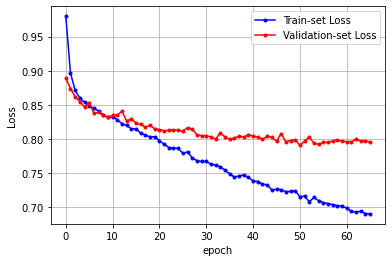

In [18]:
val_loss = history.history['val_loss']
loss = history.history['loss']


x_len = np.arange(len(loss))
plt.plot(x_len, loss, marker='.', c='blue', label="Train-set Loss")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

#### test 예측

In [19]:
submit = pd.read_csv('./data/sample_submission.csv')
submit.head()

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0


In [20]:
scaled_X_test = preprocessor.transform(test)

In [21]:
preds = model.predict_proba(scaled_X_test)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [22]:
submit.iloc[:, 1:] = preds

In [23]:
submit.head()

,index,0,1,2
0,26457,0.184501,0.026434,0.789065
1,26458,0.188908,0.057059,0.754033
2,26459,0.169106,0.220998,0.609896
3,26460,0.124352,0.144973,0.730675
4,26461,0.022852,0.109207,0.867941


In [24]:
# submit.to_csv('saved_models/submisison_DNN.csv',index=False)

### (128,128)

In [30]:
model2 = models.Sequential()

# 1-hidden layer
model2.add(layers.Dense(input_dim=scaled_X_train.shape[1], units=128, activation=None, kernel_initializer='he_uniform'))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(rate=0.3))

# 2-hidden layer
model2.add(layers.Dense(units=128, activation=None, kernel_initializer='he_uniform'))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(rate=0.3))

# Output layer
model2.add(layers.Dense(units=3, activation='softmax'))
model2.compile(optimizer=optimizers.Adam(), 
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               13312     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0

In [32]:
checkpoint_path = 'saved_models/2layer.h5'

callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         monitor='val_loss', # default
                                                         save_best_only=True, # "Save" the "best" model "only"
                                                         verbose=0)


callback_earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=15,         # 10회 Epoch동안 개선되지 않는다면 종료
                             )

In [33]:
history2 = model2.fit(scaled_X_train, train_label, 
                    validation_data=(scaled_X_val, val_label),
                    batch_size=100, epochs=1000,
                    callbacks=[callback_checkpoint, callback_earlystopping]) # 콜백 함수 추가

Epoch 1/1000
186/186 [==============================] - 3s 7ms/step - loss: 0.9948 - categorical_accuracy: 0.5878 - val_loss: 0.8797 - val_categorical_accuracy: 0.6440
Epoch 2/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.9122 - categorical_accuracy: 0.6299 - val_loss: 0.8732 - val_categorical_accuracy: 0.6553
Epoch 3/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.8789 - categorical_accuracy: 0.6441 - val_loss: 0.8573 - val_categorical_accuracy: 0.6691
Epoch 4/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.8698 - categorical_accuracy: 0.6499 - val_loss: 0.8617 - val_categorical_accuracy: 0.6704
Epoch 5/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.8628 - categorical_accuracy: 0.6510 - val_loss: 0.8533 - val_categorical_accuracy: 0.6726
Epoch 6/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.8559 - categorical_accuracy: 0.6559 - val_loss: 0.8535 - val_categorical_accuracy:

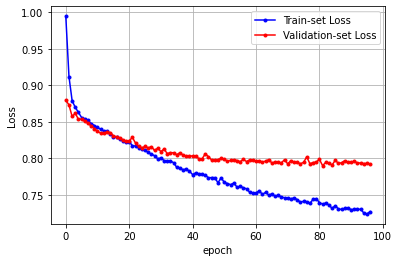

In [34]:
val_loss = history2.history['val_loss']
loss = history2.history['loss']


x_len = np.arange(len(loss))
plt.plot(x_len, loss, marker='.', c='blue', label="Train-set Loss")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

## layer3 

### (32,64,16)

In [50]:
model3 = models.Sequential()

# 1-hidden layer
model3.add(layers.Dense(input_dim=scaled_X_train.shape[1], units=32, activation=None, kernel_initializer='he_uniform'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Dropout(rate=0.3))

# 2-hidden layer
model3.add(layers.Dense(units=64, activation=None, kernel_initializer='he_uniform'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Dropout(rate=0.3))

# 3-hidden layer
model3.add(layers.Dense(units=16, activation=None, kernel_initializer='he_uniform'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Dropout(rate=0.3))

# Output layer
model3.add(layers.Dense(units=3, activation='softmax'))
model3.compile(optimizer=optimizers.Adam(), 
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy])

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               13312     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0

In [52]:
checkpoint_path = 'saved_models/2layer.h5'

callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         monitor='val_loss', # default
                                                         save_best_only=True, # "Save" the "best" model "only"
                                                         verbose=0)


callback_earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=15,         # 10회 Epoch동안 개선되지 않는다면 종료
                             )

In [53]:
history3 = model3.fit(scaled_X_train, train_label, 
                    validation_data=(scaled_X_val, val_label),
                    batch_size=100, epochs=1000,
                    callbacks=[callback_checkpoint, callback_earlystopping]) # 콜백 함수 추가

Epoch 1/1000
186/186 [==============================] - 3s 6ms/step - loss: 1.0627 - categorical_accuracy: 0.5241 - val_loss: 0.9070 - val_categorical_accuracy: 0.6405
Epoch 2/1000
186/186 [==============================] - 1s 4ms/step - loss: 0.9400 - categorical_accuracy: 0.6132 - val_loss: 0.8779 - val_categorical_accuracy: 0.6451
Epoch 3/1000
186/186 [==============================] - 1s 4ms/step - loss: 0.9081 - categorical_accuracy: 0.6341 - val_loss: 0.8681 - val_categorical_accuracy: 0.6426
Epoch 4/1000
186/186 [==============================] - 1s 4ms/step - loss: 0.8940 - categorical_accuracy: 0.6400 - val_loss: 0.8630 - val_categorical_accuracy: 0.6424
Epoch 5/1000
186/186 [==============================] - 1s 4ms/step - loss: 0.8860 - categorical_accuracy: 0.6406 - val_loss: 0.8608 - val_categorical_accuracy: 0.6424
Epoch 6/1000
186/186 [==============================] - 1s 4ms/step - loss: 0.8798 - categorical_accuracy: 0.6408 - val_loss: 0.8585 - val_categorical_accuracy:

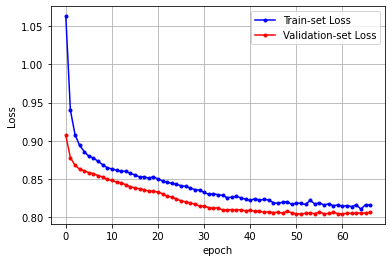

In [54]:
val_loss = history3.history['val_loss']
loss = history3.history['loss']


x_len = np.arange(len(loss))
plt.plot(x_len, loss, marker='.', c='blue', label="Train-set Loss")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

### (128,64,32)

In [65]:
model4 = models.Sequential()

# 1-hidden layer
model4.add(layers.Dense(input_dim=scaled_X_train.shape[1], units=128, activation=None, kernel_initializer='he_uniform'))
model4.add(layers.BatchNormalization())
model4.add(layers.Activation('relu'))
model4.add(layers.Dropout(rate=0.3))

# 2-hidden layer
model4.add(layers.Dense(units=64, activation=None, kernel_initializer='he_uniform'))
model4.add(layers.BatchNormalization())
model4.add(layers.Activation('relu'))
model4.add(layers.Dropout(rate=0.3))

# 3-hidden layer
model4.add(layers.Dense(units=32, activation=None, kernel_initializer='he_uniform'))
model4.add(layers.BatchNormalization())
model4.add(layers.Activation('relu'))
model4.add(layers.Dropout(rate=0.3))

# Output layer
model4.add(layers.Dense(units=3, activation='softmax'))
model4.compile(optimizer=optimizers.Adam(), 
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy])

In [66]:
model4.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 128)               6656      
_________________________________________________________________
batch_normalization_24 (Batc (None, 128)               512       
_________________________________________________________________
activation_24 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_25 (Batc (None, 64)                256       
_________________________________________________________________
activation_25 (Activation)   (None, 64)               

In [67]:
checkpoint_path = 'saved_models/3layer.h5'

callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         monitor='val_loss', # default
                                                         save_best_only=True, # "Save" the "best" model "only"
                                                         verbose=0)


callback_earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=15,         # 10회 Epoch동안 개선되지 않는다면 종료
                             )

In [68]:
history4 = model4.fit(scaled_X_train, train_label, 
                    validation_data=(scaled_X_val, val_label),
                    batch_size=100, epochs=1000,
                    callbacks=[callback_checkpoint, callback_earlystopping]) # 콜백 함수 추가

Epoch 1/1000
186/186 [==============================] - 3s 7ms/step - loss: 1.0172 - categorical_accuracy: 0.5706 - val_loss: 0.8980 - val_categorical_accuracy: 0.6474
Epoch 2/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.9243 - categorical_accuracy: 0.6232 - val_loss: 0.8756 - val_categorical_accuracy: 0.6469
Epoch 3/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.8946 - categorical_accuracy: 0.6355 - val_loss: 0.8659 - val_categorical_accuracy: 0.6509
Epoch 4/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.8846 - categorical_accuracy: 0.6403 - val_loss: 0.8631 - val_categorical_accuracy: 0.6571
Epoch 5/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.8736 - categorical_accuracy: 0.6467 - val_loss: 0.8594 - val_categorical_accuracy: 0.6601
Epoch 6/1000
186/186 [==============================] - 1s 6ms/step - loss: 0.8696 - categorical_accuracy: 0.6490 - val_loss: 0.8548 - val_categorical_accuracy:

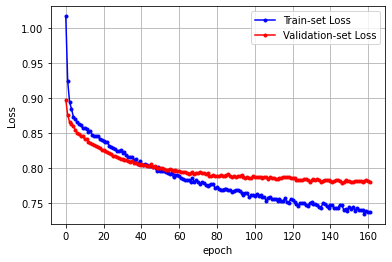

In [69]:
val_loss = history4.history['val_loss']
loss = history4.history['loss']


x_len = np.arange(len(loss))
plt.plot(x_len, loss, marker='.', c='blue', label="Train-set Loss")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

### (128,64,64)

In [70]:
model5 = models.Sequential()

# 1-hidden layer
model5.add(layers.Dense(input_dim=scaled_X_train.shape[1], units=128, activation=None, kernel_initializer='he_uniform'))
model5.add(layers.BatchNormalization())
model5.add(layers.Activation('relu'))
model5.add(layers.Dropout(rate=0.3))

# 2-hidden layer
model5.add(layers.Dense(units=64, activation=None, kernel_initializer='he_uniform'))
model5.add(layers.BatchNormalization())
model5.add(layers.Activation('relu'))
model5.add(layers.Dropout(rate=0.3))

# 3-hidden layer
model5.add(layers.Dense(units=64, activation=None, kernel_initializer='he_uniform'))
model5.add(layers.BatchNormalization())
model5.add(layers.Activation('relu'))
model5.add(layers.Dropout(rate=0.3))

# Output layer
model5.add(layers.Dense(units=3, activation='softmax'))
model5.compile(optimizer=optimizers.Adam(), 
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy])

In [71]:
model5.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 128)               6656      
_________________________________________________________________
batch_normalization_27 (Batc (None, 128)               512       
_________________________________________________________________
activation_27 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_28 (Batc (None, 64)                256       
_________________________________________________________________
activation_28 (Activation)   (None, 64)              

In [72]:
checkpoint_path = 'saved_models/3layer2.h5'

callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         monitor='val_loss', # default
                                                         save_best_only=True, # "Save" the "best" model "only"
                                                         verbose=0)


callback_earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=15,         # 10회 Epoch동안 개선되지 않는다면 종료
                             )

In [73]:
history5 = model5.fit(scaled_X_train, train_label, 
                    validation_data=(scaled_X_val, val_label),
                    batch_size=100, epochs=1000,
                    callbacks=[callback_checkpoint, callback_earlystopping]) # 콜백 함수 추가

Epoch 1/1000
186/186 [==============================] - 3s 10ms/step - loss: 1.0115 - categorical_accuracy: 0.5690 - val_loss: 0.8910 - val_categorical_accuracy: 0.6426
Epoch 2/1000
186/186 [==============================] - 2s 13ms/step - loss: 0.9248 - categorical_accuracy: 0.6267 - val_loss: 0.8697 - val_categorical_accuracy: 0.6466
Epoch 3/1000
186/186 [==============================] - 2s 10ms/step - loss: 0.8931 - categorical_accuracy: 0.6378 - val_loss: 0.8621 - val_categorical_accuracy: 0.6581
Epoch 4/1000
186/186 [==============================] - 2s 10ms/step - loss: 0.8825 - categorical_accuracy: 0.6429 - val_loss: 0.8646 - val_categorical_accuracy: 0.6631
Epoch 5/1000
186/186 [==============================] - 2s 11ms/step - loss: 0.8725 - categorical_accuracy: 0.6482 - val_loss: 0.8645 - val_categorical_accuracy: 0.6692
Epoch 6/1000
186/186 [==============================] - 2s 10ms/step - loss: 0.8679 - categorical_accuracy: 0.6495 - val_loss: 0.8549 - val_categorical_acc

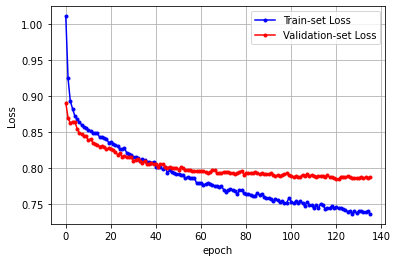

In [74]:
val_loss = history5.history['val_loss']
loss = history5.history['loss']


x_len = np.arange(len(loss))
plt.plot(x_len, loss, marker='.', c='blue', label="Train-set Loss")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

#### test 예측

In [12]:
submit = pd.read_csv('./data/sample_submission.csv')
submit.head()

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0


In [13]:
scaled_X_test = preprocessor.transform(test)

In [15]:
from tensorflow.keras import models
model = models.load_model('saved_models/3layer2.h5')
model

In [16]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 128)               6656      
_________________________________________________________________
batch_normalization_27 (Batc (None, 128)               512       
_________________________________________________________________
activation_27 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_28 (Batc (None, 64)                256       
_________________________________________________________________
activation_28 (Activation)   (None, 64)              

In [17]:
preds = model.predict_proba(scaled_X_test)
preds

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


array([[0.07884338, 0.07250788, 0.8486488 ],
       [0.15268917, 0.11483189, 0.7324789 ],
       [0.11817016, 0.28733793, 0.5944919 ],
       ...,
       [0.04070346, 0.09005092, 0.86924565],
       [0.10414562, 0.21974276, 0.6761116 ],
       [0.0145017 , 0.14422312, 0.84127516]], dtype=float32)

In [18]:
submit.iloc[:, 1:] = preds
submit.head()

,index,0,1,2
0,26457,0.078843,0.072508,0.848649
1,26458,0.152689,0.114832,0.732479
2,26459,0.118170,0.287338,0.594492
3,26460,0.097479,0.169003,0.733517
4,26461,0.043222,0.179058,0.777721


In [19]:
submit.to_csv('saved_models/3layer_best_submisison_DNN.csv',index=False)